In [15]:
import os, sys
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from pdb import set_trace as bp


In [16]:
# Set the location where plots can be saved
plot_dir = './plots/'
os.makedirs(plot_dir, exist_ok=True)

# Set the location of summary.csv
summary_file = 'summary_data/summary.csv'

In [17]:
# Read the summary CSV data file
df = pd.read_csv(summary_file)

# downcast some columns to integers for clarity
df = df.astype({"m": int, "targetID": int, "KID": int, "dimerID": int})

df.head()
# NOTE: the "goodenough" metric is Linf <= 1.0

,m,targetID,KID,dimerID,Linf,MSE,goodenough
0,12,50,21,15,1.636138,1.239475,False
1,12,685,0,75,4.332695,17.759617,False
2,10,223,13,19,6.223588,2.865953,False
3,12,683,17,25,3.943464,13.884623,False
4,10,67,0,46,2.667751,2.071588,False


In [18]:
## PLOTTING SETTINGS
plt.rcParams.update({'font.size': 22, 'legend.fontsize': 12,
                'legend.facecolor': 'white', 'legend.framealpha': 0.8,
                'legend.loc': 'upper left', 'lines.linewidth': 4.0})

default_colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])


def plot_boxes(output_fname, df, xname, yname, alpha=0.8, s=20, marker='D', showfliers=False):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [12,12])
    sns.boxplot(ax=ax, x=xname, y=yname, data=df, showfliers = showfliers, color='gray')
    if not showfliers:
        sns.stripplot(ax=ax, x=xname, y=yname, data=df, s=s, marker=marker, color='r', alpha=alpha)
    ax.set_xlabel('Network size')
    ax.set_ylim([0, 1])
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
    fig.savefig(output_fname, format='pdf')
    plt.show()

def plot_violins(output_fname, df, xname, yname):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [12,12])
    sns.violinplot(ax=ax, x=xname, y=yname, data=df, color='gray')
#     if not showfliers:
#         sns.stripplot(ax=ax, x=xname, y=yname, data=df, s=s, marker=marker, color='r', alpha=alpha)
    ax.set_xlabel('Network size')
    ax.set_ylim([0, 1])
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
    fig.savefig(output_fname, format='pdf')
    plt.show()

def plot_K_convergence(output_fname, df, xname, yname, hue):
    
    mean_yname = 'Mean of ' + yname
    df[mean_yname] = df.groupby([hue]).expanding().mean().reset_index()[yname]

    sd_yname = 'SD of ' + yname
    df[sd_yname] = df.groupby([hue]).expanding().std().reset_index()[yname]

    # make mean plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [12,12])
    sns.lineplot(ax=ax, data=df, x=xname, y=mean_yname, hue=hue)
    fig.savefig(output_fname+'_mean.pdf', format='pdf')
    plt.show()

    # make std plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [12,12])
    sns.lineplot(ax=ax, data=df, x=xname, y=sd_yname, hue=hue)
    fig.savefig(output_fname+'_std.pdf', format='pdf')
    plt.show()


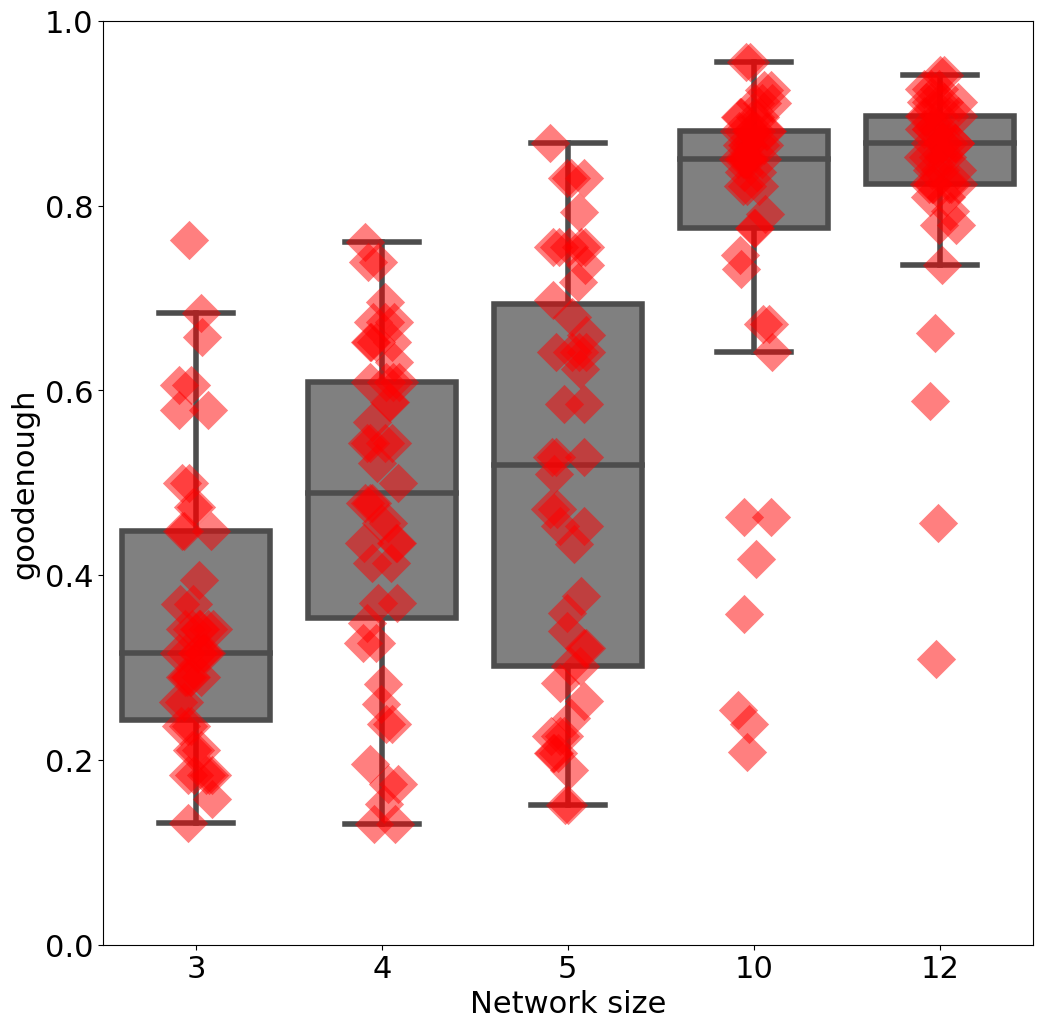

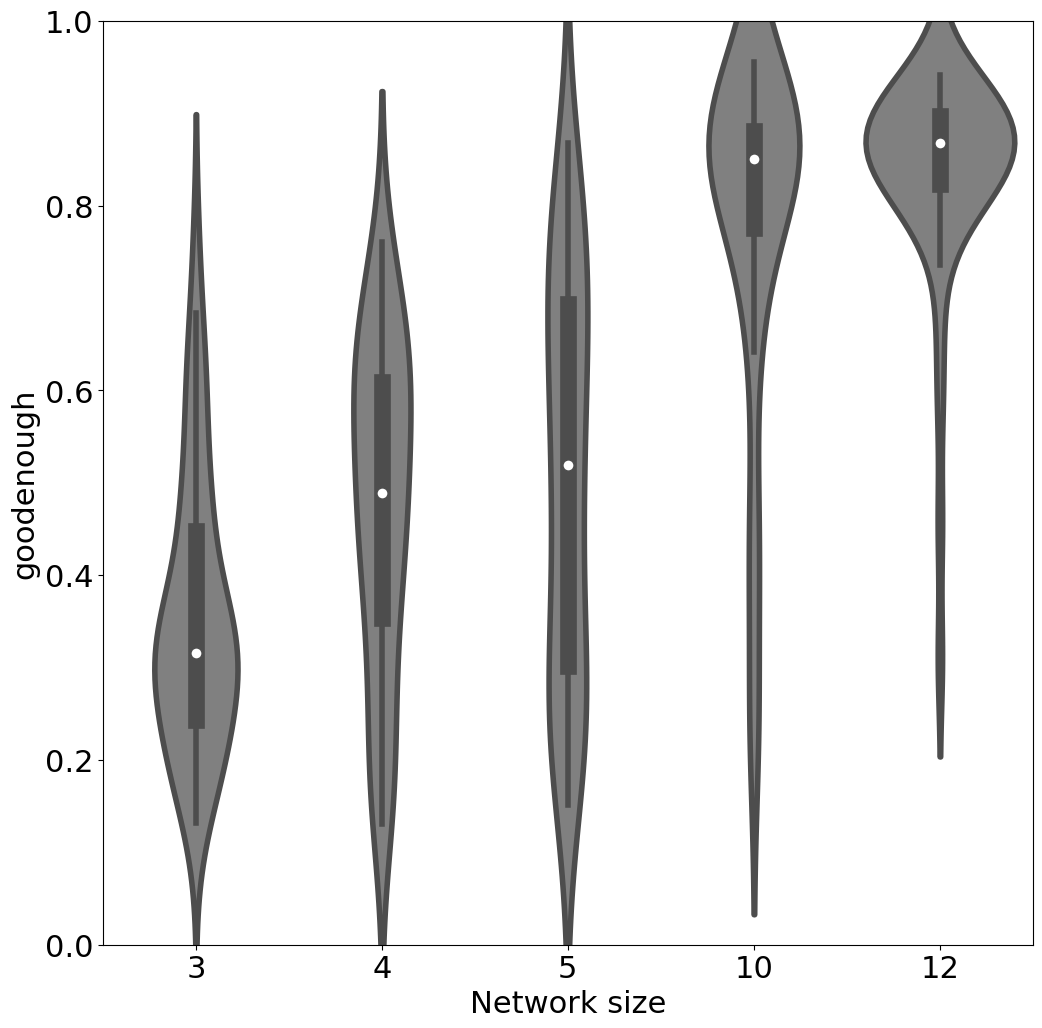

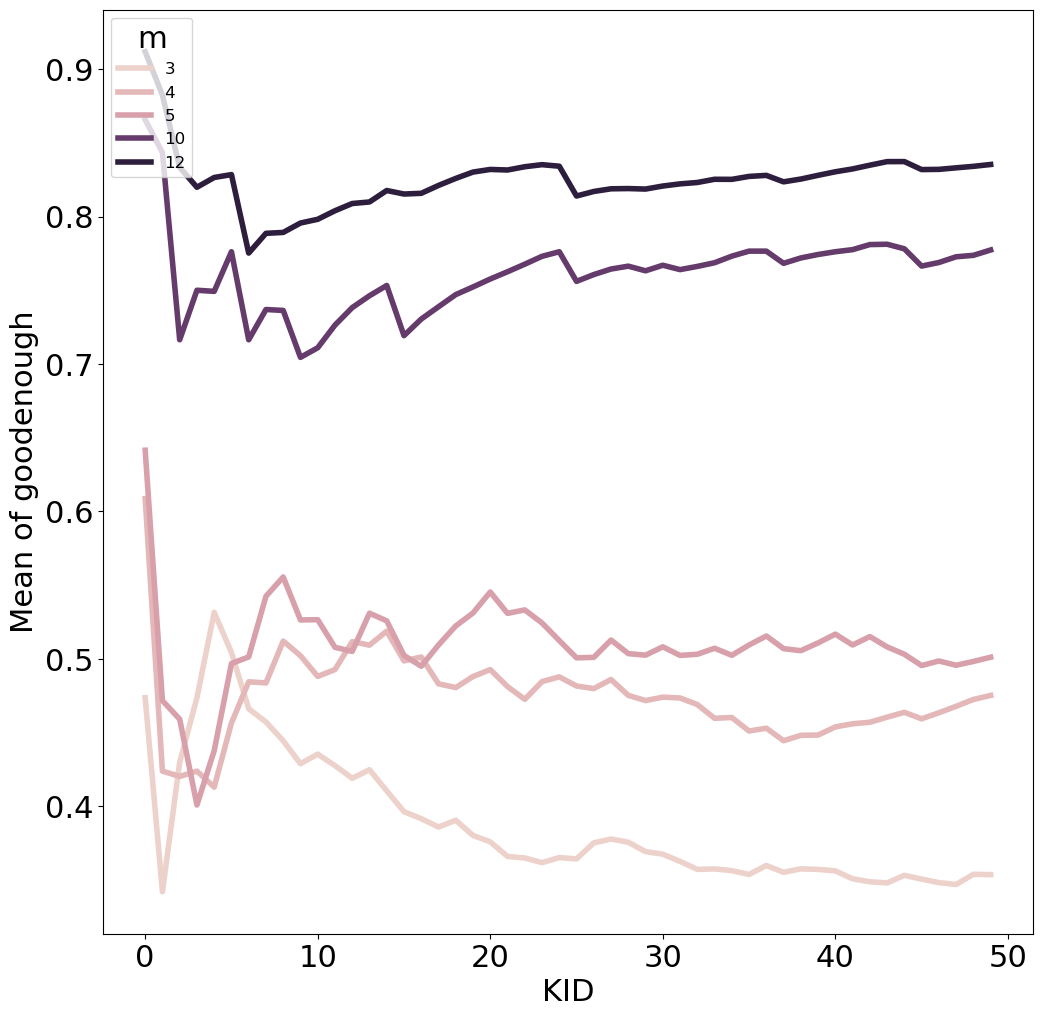

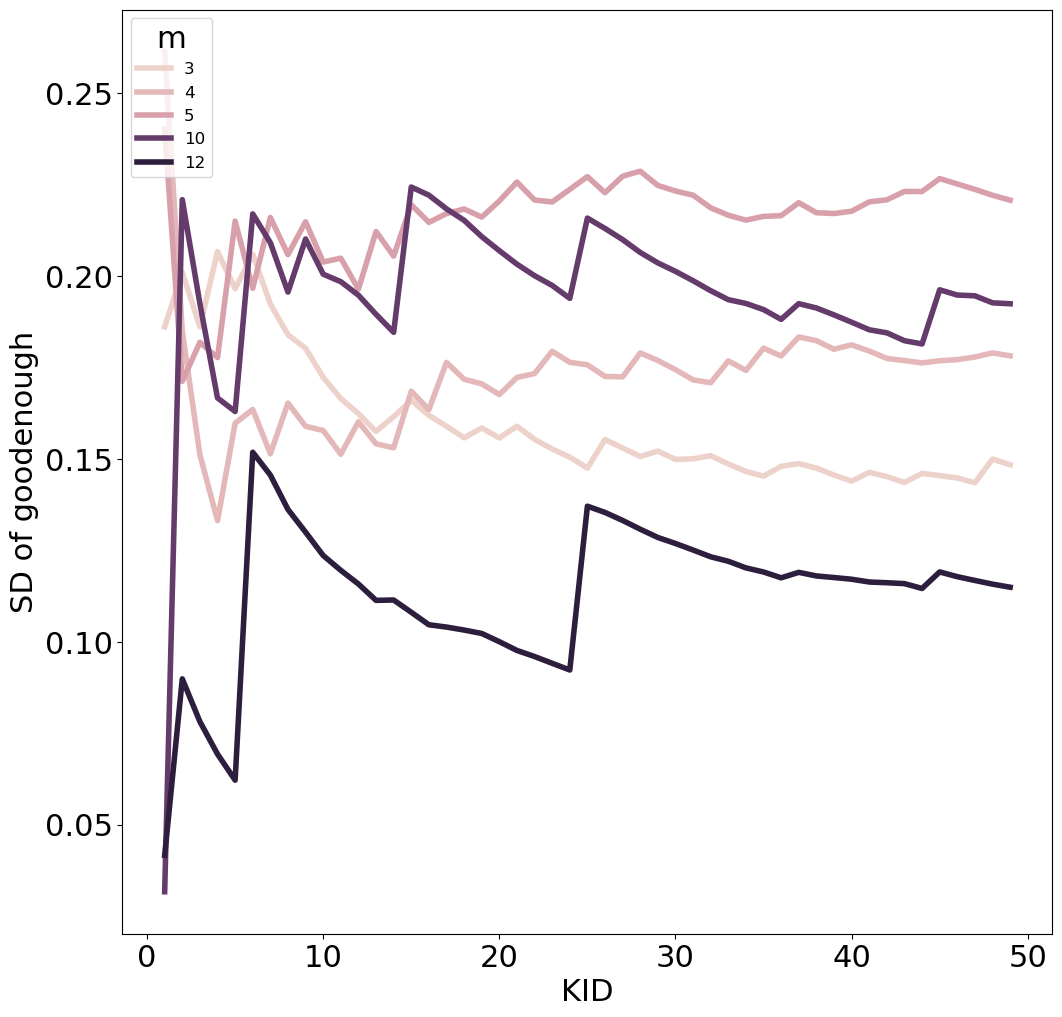

In [19]:
## Examine expressivity when maxing over output dimer
sub_df = df.copy()

# This step assigns assigns an (m, KID, targetID) pair the maximum value of "goodenough" available over all its "dimerID" values
sub_df['goodenough'] = sub_df.groupby(['m','KID','targetID'])['goodenough'].transform('max')

# Clean up a bit
sub_df = sub_df.drop(columns=['dimerID','Linf'])

# Compute the library efficiency of each (m, KID) pair by looking at the fraction of library it is "goodenough" for.
sub_df = sub_df.groupby(['m','KID']).mean().reset_index()

# Make box plot
plot_fname = os.path.join(plot_dir, 'plot_bestDimer_box.pdf')
plot_boxes(plot_fname, sub_df, xname='m', yname='goodenough', alpha=0.5)

# Make violin plot
plot_fname = os.path.join(plot_dir, 'plot_bestDimer_violin.pdf')
plot_violins(plot_fname, sub_df, xname='m', yname='goodenough')

# Plot convergence w.r.t. sampling of K
plot_K_convergence(plot_fname, sub_df, xname='KID', yname='goodenough', hue='m')


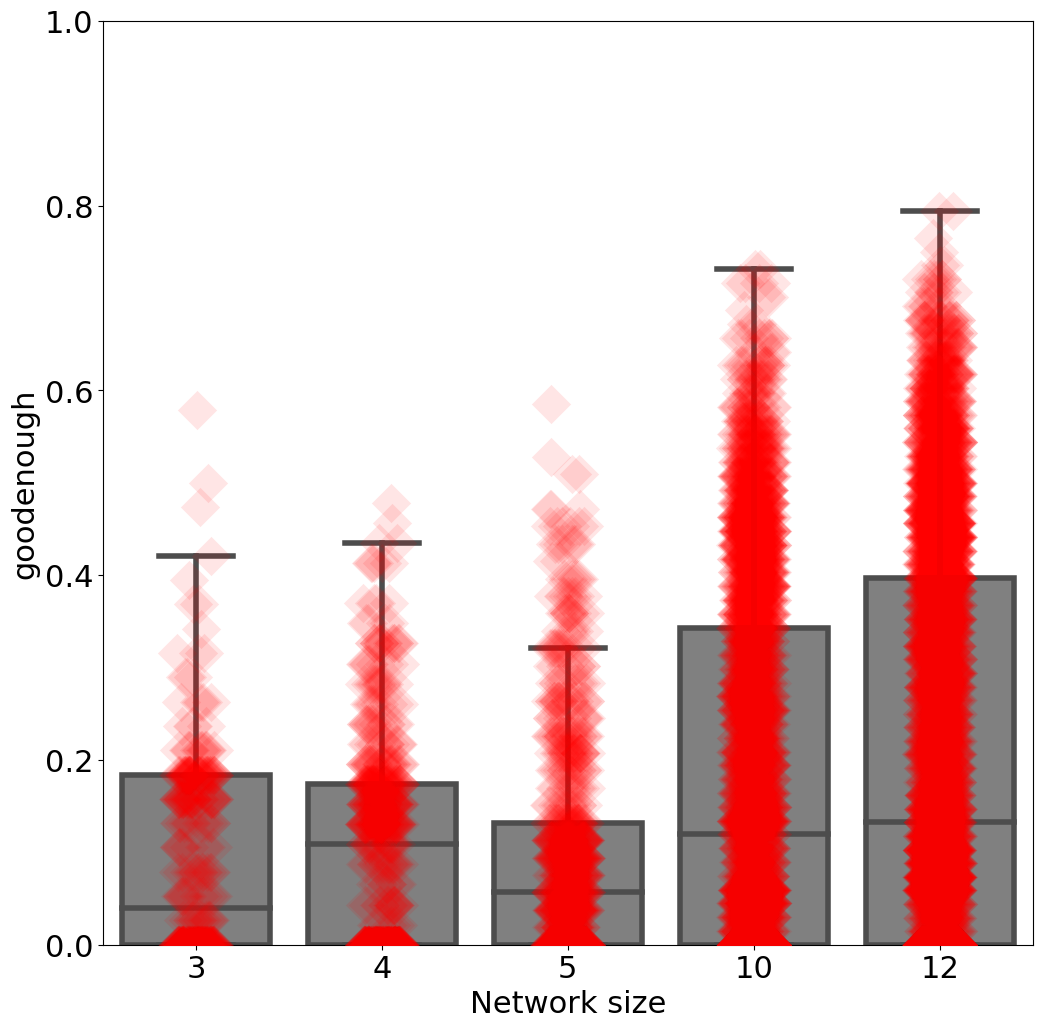

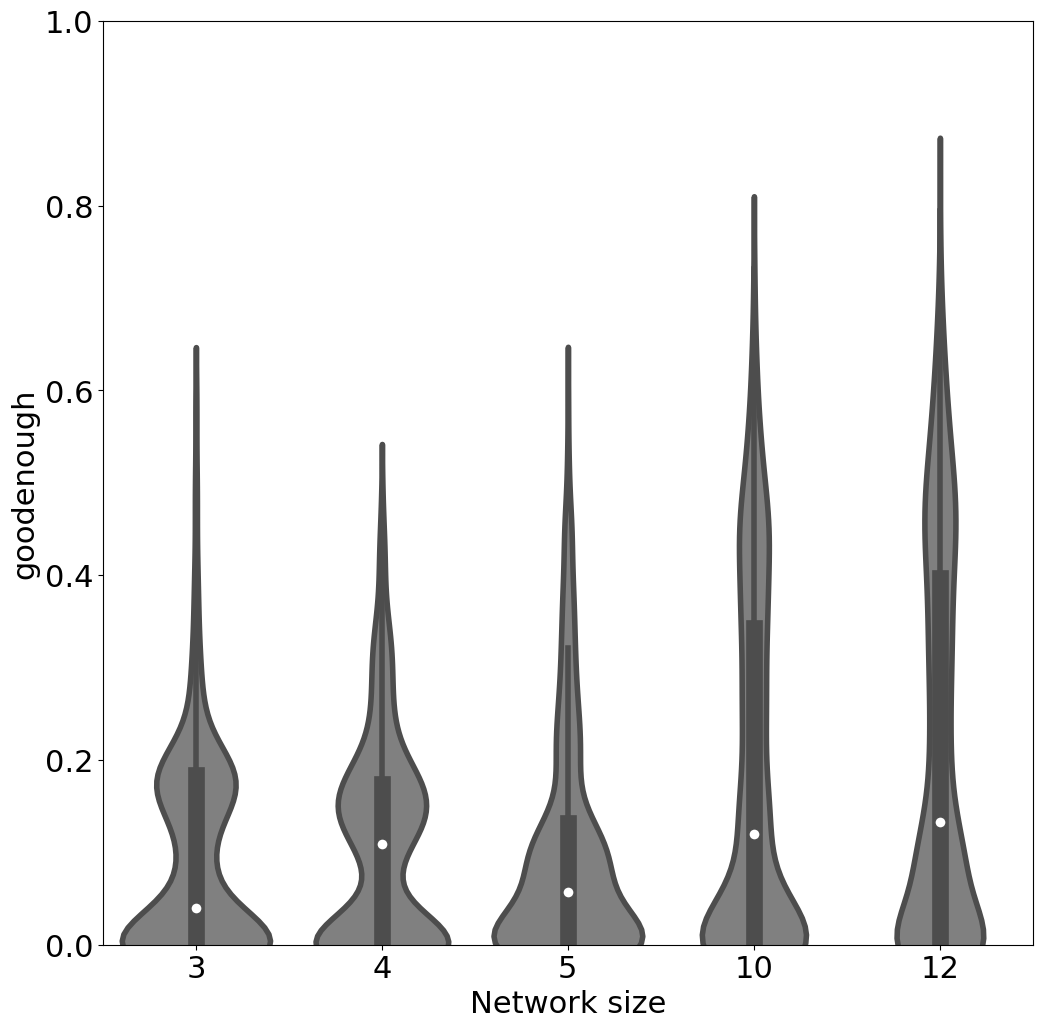

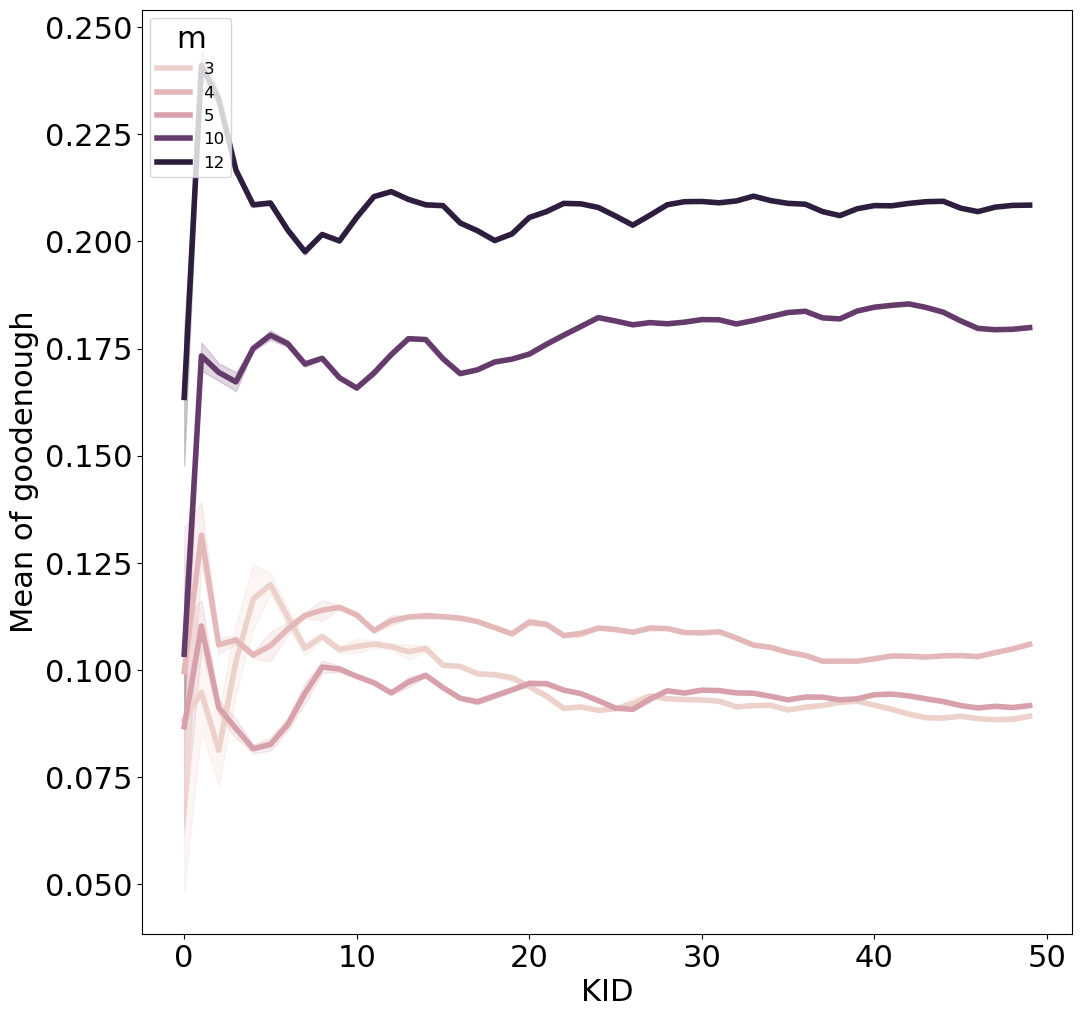

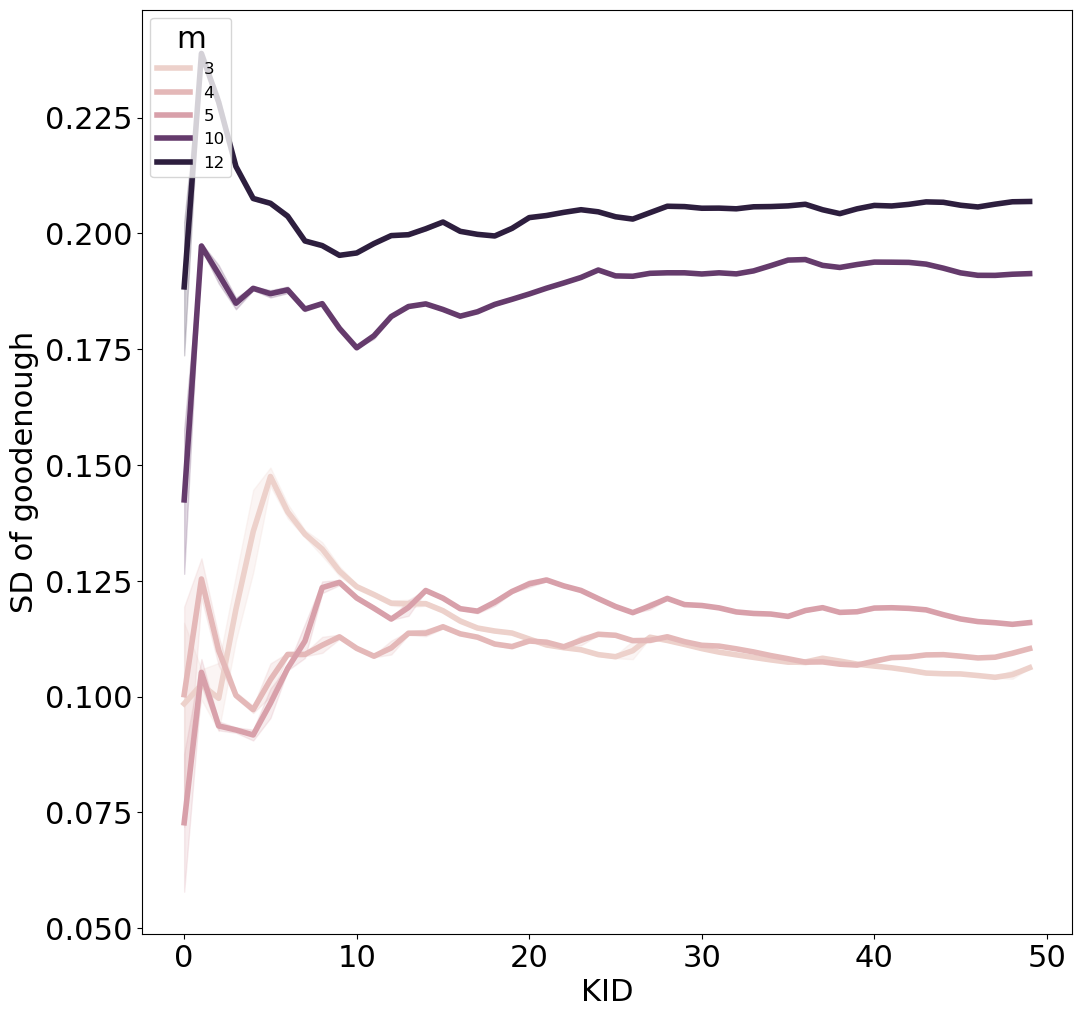

In [20]:
# Examine fits by treating all (K, dimer) pairs as independent systems

# for each m, what fraction of expressible targets can be achieved using a random K, a random output dimer, and a tuned a
df2 = df.groupby(['m','KID', 'dimerID']).mean().reset_index()

# Make box plot
plot_fname = os.path.join(plot_dir, 'plot_eachDimerSeparate_box.pdf')
plot_boxes(plot_fname, df2, xname='m', yname='goodenough', alpha=0.1)

# Make violin plot
plot_fname = os.path.join(plot_dir, 'plot_eachDimerSeparate_violin.pdf')
plot_violins(plot_fname, df2, xname='m', yname='goodenough')

# Plot convergence w.r.t. sampling of K
plot_fname = os.path.join(plot_dir, 'plot_eachDimerSeparate_convergence')
plot_K_convergence(plot_fname, df2, xname='KID', yname='goodenough', hue='m')


In [21]:
## Which 